In [8]:
pip install git

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git


In [10]:
!sudo dnf install git-all

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!git clone https://github.com/Horizon2333/imagenet-autoaencoder

'git' is not recognized as an internal or external command,
operable program or batch file.


In [115]:
!python tools/generate_list.py --name weather_test --path ../dataset

In [1]:
cd imagenet-autoencoder

c:\Users\seung\Desktop\auto_image\Mixed-AutoEncoder\imagenet-autoencoder


In [2]:
import torch
import numpy as np
from models import builer as builder
import argparse
from torchvision.transforms import transforms
import utils
import pandas as pd
import os

# Imagenet-autoencoder

## resnet34

In [3]:
from PIL import Image
from tools import encode as en
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import util_eval as ce

ModuleNotFoundError: No module named 'util_eval'

In [118]:
data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')
data

C:\Users\seung\AppData\Local\Temp\ipykernel_9948\3782592483.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')


,path,class
0,../dataset\fogsmog\4075.jpg,0
1,../dataset\fogsmog\4076.jpg,0
2,../dataset\fogsmog\4077.jpg,0
3,../dataset\fogsmog\4078.jpg,0
4,../dataset\fogsmog\4079.jpg,0
...,...,...
4128,../dataset\snow\1446.jpg,6
4129,../dataset\snow\1447.jpg,6
4130,../dataset\snow\1448.jpg,6
4131,../dataset\snow\1449.jpg,6


In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [120]:
#Let's first encoder all the file
args_dict = {
    "arch": "resnet34",
    "resume": "./caltech256-resnet34.pth",
    "parallel" : 0   
}
args_namespace = argparse.Namespace(**args_dict)

model = builder.BuildAutoEncoder(args_namespace)

In [121]:
def get_encode_vector(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    latent_vectors = []
    trans = transforms.Compose([
                transforms.Resize(256),                   
                transforms.CenterCrop(224),
                transforms.ToTensor()
                ])
    model.eval()
    for i in range(len(data)):
        path_img = data['path'].iloc[i]
        label = data['class'].iloc[i]
        img = Image.open(path_img).convert("RGB")
        img = trans(img).unsqueeze(0).to(device)
        latent_vector =  en.encode(model,img)
        latent_vectors.append(latent_vector.reshape(1,-1))
    
    return latent_vectors

In [127]:
test_vector = get_encode_vector(model, data)
test_vector_concatenated = np.concatenate(test_vector, axis=0)
test_vector_concatenated.shape

In [133]:
pca = PCA()
pca.fit(test_vector_concatenated)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

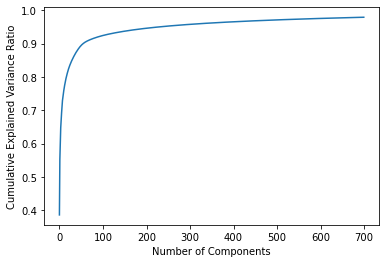

In [134]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:700])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

In [170]:
pca_resnet = PCA(n_components=700)
pca_resnet.fit(test_vector_concatenated)

test_transform_resnet = pca_resnet.transform(test_vector_concatenated)

In [171]:
test_transform_resnet.shape


(4133, 700)

#### This is for K-means clustering

In [172]:
kmeans_resnet34 = KMeans(n_clusters=7)
kmeans_resnet34.fit(test_transform_resnet)
y_kmeans = kmeans_resnet34.predict(test_transform_resnet)

KMeans(n_clusters=7)

In [174]:
label = data['class']

#### Evaluation metric

In [175]:
conf_matrix_resnet= confusion_matrix(y_kmeans, label)
print(conf_matrix_resnet)

[[  3  47 155  10  68   9 165]
 [139 177 127  37 103 151 159]
 [ 24  32  20 192  50  39   4]
 [277  33  14   6  34 147  39]
 [ 15  61 173  57 157  18  59]
 [208  32  60   6  31  77 172]
 [185  93  42  69  83 251  23]]


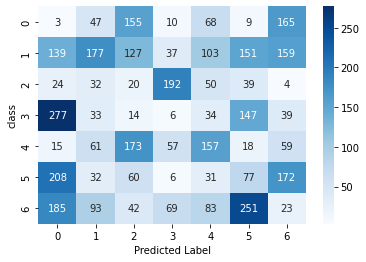

In [176]:
sns.heatmap(conf_matrix_resnet, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')

plt.show()

## Vgg16

In [143]:
args_dict = {
    "arch": "vgg16",
    "resume": "./imagenet-vgg16.pth",
    "parallel" : 0   
}
args_namespace = argparse.Namespace(**args_dict)

model_vgg = builder.BuildAutoEncoder(args_namespace)

In [144]:
vgg_vector = get_encode_vector(model_vgg, data)

In [145]:
vgg_vector_concatenated = np.concatenate(vgg_vector, axis=0)
vgg_vector_concatenated.shape

(4133, 25088)

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

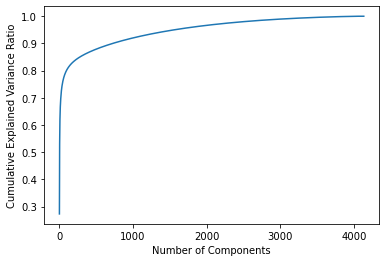

In [161]:
pca = PCA()
pca.fit(vgg_vector_concatenated)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

In [147]:
pca_vgg = PCA(n_components=700)
pca_resnet.fit(vgg_vector_concatenated)

test_transform_vgg = pca_resnet.transform(vgg_vector_concatenated)

In [157]:
kmeans_vgg16 = KMeans(n_clusters=7)
kmeans_vgg16.fit(test_transform_vgg)

KMeans(n_clusters=7)

In [158]:
y_kmeans_vgg = kmeans_vgg16.predict(test_transform_vgg)

In [ ]:
ce.monti_like_evaluation()

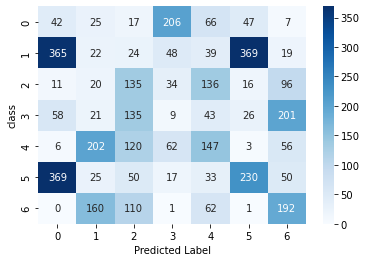

In [162]:
conf_matrix = confusion_matrix(y_kmeans_vgg, label)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')
plt.show()